In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import pandas as pd

import os

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s [%(levelname)s] %(message)s", 
                    datefmt="%d-%b-%y %H:%M:%S")

In [3]:
RULE_FOLDER = "rules_saved_clean"
PLOT_FOLDER = "plots"

assert os.path.exists(RULE_FOLDER), f"Folder {RULE_FOLDER} does not exist"

rules = os.listdir(RULE_FOLDER)
logging.info(f"Found {len(rules)} rules")

29-Apr-24 02:55:49 [INFO] Found 24 rules


In [4]:
df_exps_all = pd.read_csv("experiments.csv")
df_exps_all 

,datetime,name,MAF method,dataset,breaks,mult_rules,accuracy,f1,confusion_matrix,training_time,epochs,min_loss,all_losses,clustering_alg,label_for_dist
0,29-04-2024 01:29:37,"dataset=Brain Tumor, label_for_dist=labels, cl...",clustering,Brain Tumor,3,False,0.981399,0.979512,[[606 5]\n [ 16 502]],138.469266,117,0.017742,"[0.18103890120983124, 0.1676415055990219, 0.15...",kmeans,labels
1,29-04-2024 01:32:15,"dataset=Brain Tumor, label_for_dist=labels, cl...",random,Brain Tumor,3,False,0.983171,0.981354,[[610 1]\n [ 18 500]],157.075140,132,0.025984,"[0.24496003985404968, 0.22858241200447083, 0.2...",kmeans,labels
2,29-04-2024 01:33:19,"dataset=Brain Tumor, label_for_dist=labels, cl...",clustering,Brain Tumor,3,False,0.976971,0.974609,[[604 7]\n [ 19 499]],57.864712,53,0.019212,"[0.10689033567905426, 0.10017016530036926, 0.0...",dbscan,labels
3,29-04-2024 01:36:56,"dataset=Brain Tumor, label_for_dist=labels, cl...",random,Brain Tumor,3,False,0.983171,0.981354,[[610 1]\n [ 18 500]],216.230863,140,0.026570,"[0.2780771553516388, 0.2600518465042114, 0.243...",dbscan,labels
4,29-04-2024 01:37:15,"dataset=breast-cancer-wisconsin, label_for_dis...",clustering,breast-cancer-wisconsin,3,False,0.975610,0.965986,[[129 3]\n [ 2 71]],17.243015,73,0.022736,"[0.22843290865421295, 0.21911616623401642, 0.2...",kmeans,labels
5,29-04-2024 01:37:35,"dataset=breast-cancer-wisconsin, label_for_dis...",random,breast-cancer-wisconsin,3,False,0.975610,0.965986,[[129 3]\n [ 2 71]],19.629939,117,0.030730,"[0.3084924817085266, 0.2875896692276001, 0.267...",kmeans,labels
6,29-04-2024 01:37:57,"dataset=breast-cancer-wisconsin, label_for_dis...",clustering,breast-cancer-wisconsin,3,False,0.960976,0.944444,[[129 3]\n [ 5 68]],20.698811,88,0.025124,"[0.5811095237731934, 0.5710375308990479, 0.559...",dbscan,labels
7,29-04-2024 01:38:23,"dataset=breast-cancer-wisconsin, label_for_dis...",random,breast-cancer-wisconsin,3,False,0.970732,0.959459,[[128 4]\n [ 2 71]],24.956167,112,0.029798,"[0.25656089186668396, 0.23777367174625397, 0.2...",dbscan,labels
8,29-04-2024 01:38:40,"dataset=gaussian_df, label_for_dist=labels, cl...",clustering,gaussian_df,3,False,0.986667,0.987500,[[69 2]\n [ 0 79]],15.792498,100,0.016695,"[0.0826035887002945, 0.07975836843252182, 0.07...",kmeans,labels
9,29-04-2024 01:39:19,"dataset=gaussian_df, label_for_dist=labels, cl...",random,gaussian_df,3,False,0.986667,0.987500,[[69 2]\n [ 0 79]],39.058897,264,0.023637,"[0.2653946876525879, 0.2601081132888794, 0.254...",kmeans,labels


In [5]:
def get_pairs(rules):
    pairs = []
    for rule1 in rules:
        if 'maf_method' in rule1:
            for rule2 in rules:
                if rule1 == rule2 or (rule2, rule1) in pairs:
                    continue
                if rule2.startswith(rule1.split('maf_method')[0]):
                    pairs.append((rule1, rule2))
    return pairs

def extract_res(rules_info):
    rules = rules_info["preds"]
    mafs = rules_info["masses"]
    
    rule_names = [str(i) for i in rules]
    mass_first = [float(i[0]) for i in mafs]
    mass_second = [float(i[1]) for i in mafs]
    uncertainty = [float(i[2]) for i in mafs]
    
    res = {"rule": rule_names, "mass_first": mass_first, "mass_second": mass_second, "uncertainty": uncertainty}
    return res

In [6]:
lst = ["dataset=Brain Tumor, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=clustering", 
"dataset=Brain Tumor, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=random",
"dataset=breast-cancer-wisconsin, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=clustering",
"dataset=breast-cancer-wisconsin, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=random",
"dataset=gaussian_df, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=clustering",
"dataset=gaussian_df, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=random",
"dataset=rectangle_df, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=clustering",
"dataset=rectangle_df, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=random",
"dataset=uniform_df, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=clustering",
"dataset=uniform_df, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=random"]

lst = df_exps_all.name.tail(42).to_list()
len(lst)

24

In [7]:
pairs = get_pairs(rules)

In [8]:

def filter_pairs(pairs, allowed_lst):
    relevant = []
    for i, j in pairs:
        if i.split(".")[0] in allowed_lst and j.split(".")[0] in allowed_lst:
            relevant.append((i, j)) 
            
    return relevant


pairs_new = filter_pairs(pairs,lst)
len(pairs_new)


12

In [9]:


rule_dfs_all = {}

for r1, r2 in pairs_new:
    print(r1, r2, sep="\n")
    r1_info = pickle.load(open(os.path.join(RULE_FOLDER, r1), "rb"))
    r2_info = pickle.load(open(os.path.join(RULE_FOLDER, r2), "rb"))
    
    r1_df = pd.DataFrame(extract_res(r1_info))
    r2_df = pd.DataFrame(extract_res(r2_info))
    
    
    merged = pd.merge(r1_df, r2_df, on="rule", suffixes=('_kmeans', '_random'))
    # merged.to_csv(f"rules_{r1}_{r2}.csv", index=False)
    # print(merged)
    # print(f"Num rules {len(merged)}")
    # fig = px.bar(merged, x='rule', y=['uncertainty_kmeans', 'uncertainty_random'], 
    #     title='Uncertainty comparison between kmeans and random', # put bars next to each other
    #     barmode='group')
    # fig.write_html(f"{r1}_{r2}.html")
    rule_dfs_all[r1] = merged 
    # fig.show()

dataset=Brain Tumor, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=clustering.dsb
dataset=Brain Tumor, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=random.dsb


c:\Users\hayk_\.conda\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dataset=Brain Tumor, label_for_dist=labels, clust=kmeans, breaks=3, add_mult_rules=False, maf_method=clustering.dsb
dataset=Brain Tumor, label_for_dist=labels, clust=kmeans, breaks=3, add_mult_rules=False, maf_method=random.dsb
dataset=breast-cancer-wisconsin, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=clustering.dsb
dataset=breast-cancer-wisconsin, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=random.dsb
dataset=breast-cancer-wisconsin, label_for_dist=labels, clust=kmeans, breaks=3, add_mult_rules=False, maf_method=clustering.dsb
dataset=breast-cancer-wisconsin, label_for_dist=labels, clust=kmeans, breaks=3, add_mult_rules=False, maf_method=random.dsb
dataset=gaussian_df, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=clustering.dsb
dataset=gaussian_df, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=random.dsb
dataset=gaussian_df, label_for_dist=labe

In [10]:
df_exps_all

,datetime,name,MAF method,dataset,breaks,mult_rules,accuracy,f1,confusion_matrix,training_time,epochs,min_loss,all_losses,clustering_alg,label_for_dist
0,29-04-2024 01:29:37,"dataset=Brain Tumor, label_for_dist=labels, cl...",clustering,Brain Tumor,3,False,0.981399,0.979512,[[606 5]\n [ 16 502]],138.469266,117,0.017742,"[0.18103890120983124, 0.1676415055990219, 0.15...",kmeans,labels
1,29-04-2024 01:32:15,"dataset=Brain Tumor, label_for_dist=labels, cl...",random,Brain Tumor,3,False,0.983171,0.981354,[[610 1]\n [ 18 500]],157.075140,132,0.025984,"[0.24496003985404968, 0.22858241200447083, 0.2...",kmeans,labels
2,29-04-2024 01:33:19,"dataset=Brain Tumor, label_for_dist=labels, cl...",clustering,Brain Tumor,3,False,0.976971,0.974609,[[604 7]\n [ 19 499]],57.864712,53,0.019212,"[0.10689033567905426, 0.10017016530036926, 0.0...",dbscan,labels
3,29-04-2024 01:36:56,"dataset=Brain Tumor, label_for_dist=labels, cl...",random,Brain Tumor,3,False,0.983171,0.981354,[[610 1]\n [ 18 500]],216.230863,140,0.026570,"[0.2780771553516388, 0.2600518465042114, 0.243...",dbscan,labels
4,29-04-2024 01:37:15,"dataset=breast-cancer-wisconsin, label_for_dis...",clustering,breast-cancer-wisconsin,3,False,0.975610,0.965986,[[129 3]\n [ 2 71]],17.243015,73,0.022736,"[0.22843290865421295, 0.21911616623401642, 0.2...",kmeans,labels
5,29-04-2024 01:37:35,"dataset=breast-cancer-wisconsin, label_for_dis...",random,breast-cancer-wisconsin,3,False,0.975610,0.965986,[[129 3]\n [ 2 71]],19.629939,117,0.030730,"[0.3084924817085266, 0.2875896692276001, 0.267...",kmeans,labels
6,29-04-2024 01:37:57,"dataset=breast-cancer-wisconsin, label_for_dis...",clustering,breast-cancer-wisconsin,3,False,0.960976,0.944444,[[129 3]\n [ 5 68]],20.698811,88,0.025124,"[0.5811095237731934, 0.5710375308990479, 0.559...",dbscan,labels
7,29-04-2024 01:38:23,"dataset=breast-cancer-wisconsin, label_for_dis...",random,breast-cancer-wisconsin,3,False,0.970732,0.959459,[[128 4]\n [ 2 71]],24.956167,112,0.029798,"[0.25656089186668396, 0.23777367174625397, 0.2...",dbscan,labels
8,29-04-2024 01:38:40,"dataset=gaussian_df, label_for_dist=labels, cl...",clustering,gaussian_df,3,False,0.986667,0.987500,[[69 2]\n [ 0 79]],15.792498,100,0.016695,"[0.0826035887002945, 0.07975836843252182, 0.07...",kmeans,labels
9,29-04-2024 01:39:19,"dataset=gaussian_df, label_for_dist=labels, cl...",random,gaussian_df,3,False,0.986667,0.987500,[[69 2]\n [ 0 79]],39.058897,264,0.023637,"[0.2653946876525879, 0.2601081132888794, 0.254...",kmeans,labels


In [46]:
def perform_all_for_dataset(rule_dfs_all, df_exps_all, dataset, clust_alg="kmeans"):
    
    
    rule_dfs = {k: v for k, v in rule_dfs_all.items() if dataset in k and clust_alg in k}
    print(f"Found {len(rule_dfs) * 2} experiments for dataset {dataset}")
    
    df_exps = df_exps_all[(df_exps_all.dataset == dataset) & (df_exps_all.clustering_alg == clust_alg)]
    
    plots_lst = os.listdir(PLOT_FOLDER)
    plots_exp = [i for i in plots_lst if dataset in i and clust_alg in i]

    assert len(rule_dfs) * 2 == len(df_exps) == len(plots_exp), f"Lengths do not match {len(rule_dfs) * 2} {len(df_exps)} {len(plots_exp)}"
    
    # all_losses = df_exps.all_losses
    
    losses_random = eval(df_exps[df_exps["MAF method"] == "random"].all_losses.values[0])
    epochs_random = list(range(1, len(losses_random)+1))
    
    
    losses_kmeans = eval(df_exps[df_exps["MAF method"] == "clustering"].all_losses.values[0])
    epochs_kmeans = list(range(1, len(losses_kmeans)+1))
    
    plt.style.use('ggplot')
    plt.plot(epochs_random, losses_random, label="Random")
    plt.plot(epochs_kmeans, losses_kmeans, label="Kmeans")
    plt.legend()

    plt.xlabel('Epochs')
    plt.ylabel('Loss')    
    plt.title(f"{dataset} dataset | Loss over epochs per MAF method")
    # plt.show()    
    
    cols = ['dataset', "clustering_alg", "MAF method", "accuracy", "f1", "training_time", "epochs", "min_loss"]
    
    rules_name = list(rule_dfs.keys()) 
    rules_df = rule_dfs[rules_name[0]]
    return rules_df
    # custom scoring
    for method in ["kmeans", "random"]: 
        rules_df[f'ratio_{method}'] = np.where(rules_df[f'mass_first_{method}'] > rules_df[f'mass_second_{method}'],
                            rules_df[f'mass_first_{method}'] / (d[f'mass_second_{method}'] + 1e-2),
                            rules_df[f'mass_second_{method}'] / (d[f'mass_first_{method}'] + 1e-2))
        rules_df["1_min_uncertainty"] = 1 - rules_df[f"uncertainty_{method}"] 
        rules_df[f"ratio_min_max_scaled_{method}"] = (rules_df[f'ratio_{method}'] - rules_df[f'ratio_{method}'].min()) / (rules_df[f'ratio_{method}'].max() - rules_df[f'ratio_{method}'].min())
        
        # harmonic mean
        rules_df[f"score_{method}"] = 2 / (1/rules_df[f"1_min_uncertainty"] + 1/rules_df[f"ratio_min_max_scaled_{method}"])
        
    
    uncs = rules_df[["uncertainty_kmeans", "uncertainty_random"]]
    
    uncs.plot()
    # plt.show()
    return rules_df
    return uncs.describe()#, rules_df["uncertainty_random"].describe()
    
    
    return rules_df
    
    
    return rules_df
    
    
    
    return df_exps[cols]
    


In [47]:
res

{'Brain Tumor': {'random': 1.0}}

Found 2 experiments for dataset Brain Tumor
9
9
Found 2 experiments for dataset breast-cancer-wisconsin
7
7
Found 2 experiments for dataset gaussian_df
1
1
Found 2 experiments for dataset rectangle_df
1
1
Found 2 experiments for dataset uniform_df
1
1
Found 2 experiments for dataset wine
10
10


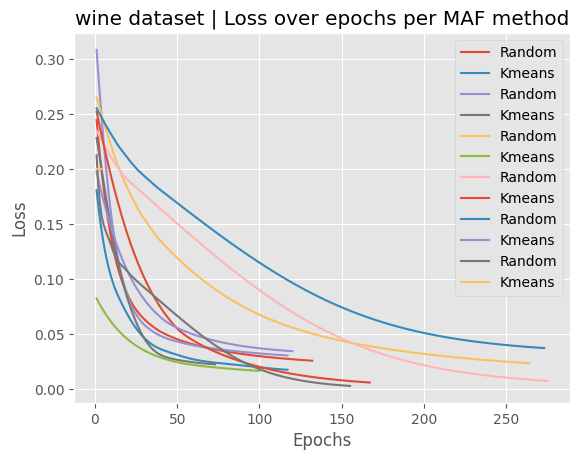

In [57]:
res = {}
for data in datasets:
    data = data.split(".")[0]
    d = perform_all_for_dataset(rule_dfs_all, df_exps_all, data)#.to_latex()

    method = "kmeans"

    # d[f"raio_{method}"] = d[f"mass_second_{method}"] / d[f"mass_first_{method}"]
    for method in ["kmeans", "random"]: 
        d[f'ratio_{method}'] = np.where(d[f'mass_first_{method}'] > d[f'mass_second_{method}'],
                            d[f'mass_first_{method}'] / (d[f'mass_second_{method}'] + 1e-2),
                            d[f'mass_second_{method}'] / (d[f'mass_first_{method}'] + 1e-2))
        d["1_min_uncertainty"] = 1 - d[f"uncertainty_{method}"]
        
        d[f"ratio_min_max_scaled_{method}"] = (d[f'ratio_{method}'] - d[f'ratio_{method}'].min()) / (d[f'ratio_{method}'].max() - d[f'ratio_{method}'].min())
        
        # harmonic mean
        d[f"score_{method}"] = 2 / (1/d[f"1_min_uncertainty"] + 1/d[f"ratio_min_max_scaled_{method}"]) 
        
    def most_imp(d, alg, rules_percantage=0.2):
        score = d.sort_values(by=f"score_{alg}", ascending=False)
        unc = d.sort_values(f"uncertainty_{alg}")  
        # num of rules in top 10 that 
        
        num_rules = int(len(score) * rules_percantage)
        print(num_rules)
        score_top = set(score.rule.iloc[:num_rules].to_list()) 
        unc_top = set(unc.rule.iloc[:num_rules].to_list()) 
        return len(score_top & unc_top) / num_rules
        
    # for method in ["kmeans", "random"]: 
    res[data] = {}
    res[data]["kmeans"] = most_imp(d, "kmeans")
    res[data]["random"] = most_imp(d, "random")
    
        


In [64]:
pd.DataFrame(res).round(2).rename({"kmeans":"clustering"})


,Brain Tumor,breast-cancer-wisconsin,gaussian_df,rectangle_df,uniform_df,wine
clustering,0.56,0.43,1.0,1.0,1.0,1.0
random,1.00,1.00,1.0,1.0,1.0,0.5


# new scoring method

In [15]:
d.head(2)

,rule,mass_first_kmeans,mass_second_kmeans,uncertainty_kmeans,mass_first_random,mass_second_random,uncertainty_random
0,clump_thickness < 2.569,0.725134,0.111726,0.16314,0.336098,0.0,0.663902
1,2.569 < clump_thickness < 4.454,0.638576,0.183734,0.17769,0.367823,0.0,0.632177


In [24]:
method = "kmeans"



# d[f"raio_{method}"] = d[f"mass_second_{method}"] / d[f"mass_first_{method}"]
for method in ["kmeans", "random"]: 
    d[f'ratio_{method}'] = np.where(d[f'mass_first_{method}'] > d[f'mass_second_{method}'],
                        d[f'mass_first_{method}'] / (d[f'mass_second_{method}'] + 1e-2),
                        d[f'mass_second_{method}'] / (d[f'mass_first_{method}'] + 1e-2))
    d["1_min_uncertainty"] = 1 - d[f"uncertainty_{method}"]
    
    d[f"ratio_min_max_scaled_{method}"] = (d[f'ratio_{method}'] - d[f'ratio_{method}'].min()) / (d[f'ratio_{method}'].max() - d[f'ratio_{method}'].min())
    
    # harmonic mean
    d[f"score_{method}"] = 2 / (1/d[f"1_min_uncertainty"] + 1/d[f"ratio_min_max_scaled_{method}"]) 

In [31]:
d.head(1)

,rule,mass_first_kmeans,mass_second_kmeans,uncertainty_kmeans,mass_first_random,mass_second_random,uncertainty_random,ratio_kmeans,ratio_random,1_min_uncertainty,ratio_min_max_scaled_kmeans,score_kmeans,ratio_min_max_scaled_random,score_random
0,clump_thickness < 2.569,0.725134,0.111726,0.16314,0.336098,0.0,0.663902,5.9571,33.60984,0.336098,0.059571,0.111225,0.760554,0.466184


In [41]:
def most_imp(d, alg, rules_percantage=0.1):
    score = d.sort_values(by=f"score_{alg}", ascending=False)
    unc = d.sort_values(f"uncertainty_{alg}")  
    # num of rules in top 10 that 
    
    num_rules = int(len(score) * rules_percantage)
    score_top = set(score.rule.iloc[:num_rules].to_list()) 
    unc_top = set(unc.rule.iloc[:num_rules].to_list()) 
    print(len(score_top & unc_top) / num_rules)
    
most_imp(d, "kmeans")

0.3333333333333333


In [33]:

# d.to_latex()

datasets = os.listdir("datasets")
datasets

['Brain Tumor.csv',
 'breast-cancer-wisconsin.csv',
 'gaussian_df.csv',
 'rectangle_df.csv',
 'uniform_df.csv',
 'wine.csv']

In [173]:
df_exps_all.columns

Index(['datetime', 'name', 'MAF method', 'dataset', 'breaks', 'mult_rules',
       'accuracy', 'f1', 'confusion_matrix', 'training_time', 'epochs',
       'min_loss', 'all_losses', 'clustering_alg', 'label_for_dist'],
      dtype='object')

# Misc

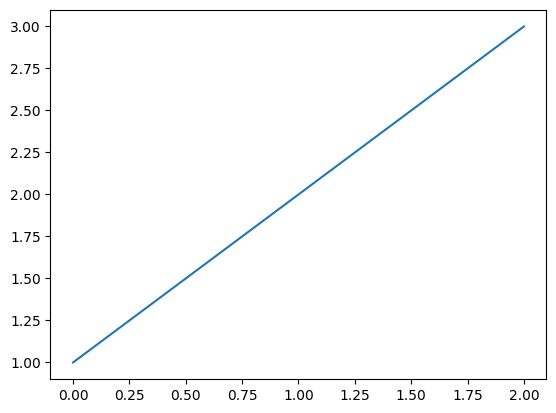

In [30]:
a = plt.plot([1,2,3])

# to latex


In [27]:
inds = [3, 31, 18, 7, 15, 34, 18]
merged["ratio"] = merged["mass_second_kmeans"] / merged["mass_first_kmeans"]
m = merged.sort_values(by="uncertainty_kmeans", ascending=True)
a = px.scatter(m.loc[inds], x="uncertainty_kmeans", y="ratio", hover_data=["rule"])

NameError: name 'merged' is not defined

In [60]:
m.loc[[7, 3]].drop(["mass_first_random", "mass_second_random",	"uncertainty_random"],axis=1)

,rule,mass_first_kmeans,mass_second_kmeans,uncertainty_kmeans,ratio
7,size_uniformity > 5.134,0.140512,0.534107,0.325381,3.801164
3,clump_thickness > 6.339,0.074992,0.590052,0.334956,7.868188


In [7]:
rules_info = pickle.load(open(f"{RULE_FOLDER}/{rules[0]}", "rb"))

c:\Users\hayk_\.conda\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
name_1 = "kmeans_wine.csv, 3 single breaks, maf_method=random.dsb"
name_2 = "kmeans_wine.csv, 3 single breaks, maf_method=kmeans.dsb"

In [13]:
rules_info_random = pickle.load(open(f"{RULE_FOLDER}/{name_1}", "rb"))
rules_info_kmeans = pickle.load(open(f"{RULE_FOLDER}/{name_2}", "rb"))

In [30]:
def extract_res(rules_info):
    rules = rules_info["preds"]
    mafs = rules_info["masses"]
    
    rule_names = [str(i) for i in rules]
    mass_first = [float(i[0]) for i in mafs]
    mass_second = [float(i[1]) for i in mafs]
    uncertainty = [float(i[2]) for i in mafs]
    
    res = {"rule": rule_names, "mass_first": mass_first, "mass_second": mass_second, "uncertainty": uncertainty}
    return res

In [31]:
kmeans = extract_res(rules_info_kmeans)
random = extract_res(rules_info_random)

In [41]:
kmeans_df = pd.DataFrame(kmeans)
random_df = pd.DataFrame(random)

# merge on rule column
merged = pd.merge(kmeans_df, random_df, on="rule", suffixes=('_kmeans', '_random'))
merged.head(1)

,rule,mass_first_kmeans,mass_second_kmeans,uncertainty_kmeans,mass_first_random,mass_second_random,uncertainty_random
0,fixed acidity < 6.350,0.231988,0.532523,0.23549,0.019433,0.287232,0.693334


In [44]:
px.bar(merged, x='rule', y=['uncertainty_kmeans', 'uncertainty_random'], 
       title='Uncertainty comparison between kmeans and random', # put bars next to each other
         barmode='group')